# Outline
- change learning rate to 0.07 from 0.05 -> score increase from 5560 to 5590 
- exclude 7 outlier 
    - learning rate:

In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

from scipy.stats import norm, stats
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import r2_score

/Users/chloe/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('/Users/chloe/Documents/GitHub/Kaggle_competition/TBrain/Yushan/Dataset/train.csv')

In [3]:
df.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,1.421501e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05


<h1>Handle Missing value</h1>

Missing value percentage by column: 

parking_area             94.828333
parking_price            76.775000
txn_floor                26.503333
village_income_median     1.903333
dtype: float64


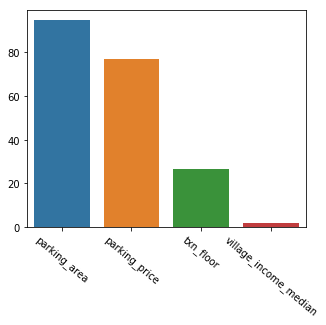

In [5]:
train_na = (df.isnull().sum() / len(df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]

print("Missing value percentage by column: \n")
print(train_na)

f, ax = plt.subplots(figsize=(5, 4))
plt.xticks(rotation='-40')
sns.barplot(x=train_na.index, y=train_na)

<h3>Remove "parking_area" due to over 94% missing value percentage</h3>

In [6]:
df = df.drop(['parking_area'], axis=1)

<h3>Fill NA value by features</h3>

In [9]:
# null parking_price all with parking_way=2 -> can directly replace the null with zero
df['parking_price'] = df['parking_price'].fillna(0)
df['village_income_median'] = df['village_income_median'].fillna(df['village_income_median'].mean())
df['txn_floor'] = df['txn_floor'].fillna(0)

<h1>Observe total_price distribution</h1>

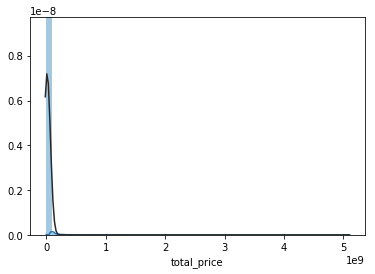

In [10]:
sns.distplot(df['total_price'] , fit=norm)

<h3>total_price's distribution is screwed right and has outlier</h3>

In [11]:
#handle screwed right
df["total_price"] = np.log1p(df["total_price"])

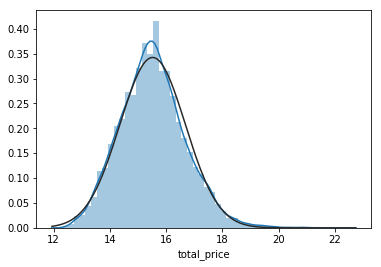

In [12]:
sns.distplot(df['total_price'] , fit=norm)

# of data exclude outlier: 7


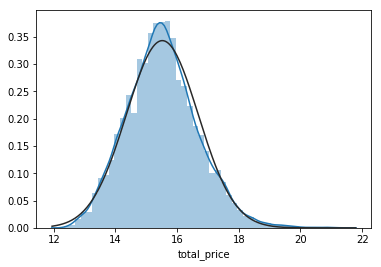

In [19]:
#handle outlier (removing outlier make it worse)
q = df["total_price"].quantile(0.9999)

df = df[df["total_price"] < q]
#df = df[df["total_price"] < q]

print("# of data exclude outlier:", 60000-test.shape[0])
sns.distplot(test["total_price"], fit=norm)

<h1>Create training and testing set</h1>

In [20]:
#remove useless feature
df = df.drop(['building_id'], axis=1)

In [21]:
#splite to X, y dataframe
df_price = df['total_price']
df = df.drop(['total_price'], axis=1)

In [22]:
random_seed = 5 # set seed for same train test data split
X_train, X_test, y_train, y_test = train_test_split(df, df_price, random_state=random_seed, test_size = 0.2)

<h1>Use random search to find best parameters for lightGBM</h1>

In [23]:
# %%time
# hyper_space = {'n_estimators': sp_randint(1000, 7000),
#                'max_depth':  [15, 16, 17, 18, 19, 20 ,-1],
#                'num_leaves': [20,30,40, 50, 60, 70, 80],
#                'subsample': sp_uniform(0.6, 0.4),
#                'colsample_bytree': sp_uniform(0.6, 0.4)}

# gbm = lgb.LGBMRegressor(objective='regression',num_leaves=250,learning_rate=0.05,n_estimators=1500)

# rs = RandomizedSearchCV(gbm, hyper_space, n_iter=60, scoring='r2', cv=4, 
#                          verbose=1, random_state=2018)
# rs_results = rs.fit(X_train, y_train)
# print("BEST PARAMETERS: " + str(rs_results.best_params_))
# print("BEST CV SCORE: " + str(rs_results.best_score_))

In [33]:
# directly using optimize parameters
# original learning_rate = 0.05 
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=30,
                        #learning_rate=0.05,
                        learning_rate=0.03,
                        n_estimators=6843,
                       colsample_bytree = 0.7544604487797361,
                       max_depth = 17,
                       subsample = 0.7198181572347372)

In [ ]:
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

<h3>Evaluate model by hit rate</h3>

In [ ]:
# baseline: 0.54; using exclude outlier: 0.55 but public score low
# changing learning rate to 0.01 -> 0.495; 0.1 -> 0.538; 0.07 -> 0.548; 0.09 -> 0.5386; 0.08 -> 0.5378

# while exclude outlier: 0.07 -> 0.5396; 0.05 -> 0.540; 0.1 -> 0.538; 0
p = np.abs(( np.exp(y_pred) - np.exp(y_test) )/ np.exp(y_test))
np.sum((p <=.1))/len(y_pred)

<h1>Predict test value for submission</h1>

In [86]:
test_df = pd.read_csv('/Users/chloe/Documents/GitHub/Kaggle_competition/TBrain/Yushan/Dataset/test.csv')
test_df = test_df.drop(['building_id','parking_area'], axis=1)

<h3>Fit the shape of training data</h3>

In [87]:
test_df['parking_price'] = test_df['parking_price'].fillna(0)
test_df['village_income_median'] = test_df['village_income_median'].fillna(test_df['village_income_median'].mean())
test_df['txn_floor'] = test_df['txn_floor'].fillna(0)

<h3>Predict...</h3>

In [88]:
# Predict value
y_sub_GBM = gbm.predict(test_df)

# Get inverse of log value
y_sub_GBM = np.exp(y_sub_GBM)

In [89]:
output = pd.read_csv('/Users/chloe/Documents/GitHub/Kaggle_competition/TBrain/Yushan/Dataset/test.csv')
output = output[["building_id"]]

In [90]:
output["total_price"] = y_sub_GBM

In [91]:
output.to_csv("/Users/chloe/Desktop/submission_learning_rate_20190531.csv", index=False)